<a href="https://colab.research.google.com/github/asyraffff/eICU-UMMC-Length-Of-Stay-Prediction/blob/main/3_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.inspection import permutation_importance

# import Regression libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# import warning library to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None)

In [ ]:
df_cardiac_ed = pd.read_csv("drive/My Drive/FYP_LOS/dataset/cardiac_ed.csv", low_memory=False)
df_cardiac_ed_no_outliers = pd.read_csv("drive/My Drive/FYP_LOS/dataset/cardiac_ed_no_outliers.csv", low_memory=False)
df_cardiac_ed_quantile = pd.read_csv("drive/My Drive/FYP_LOS/dataset/cardiac_ed_quantile.csv", low_memory=False)

df_ppum = pd.read_csv("drive/My Drive/FYP_LOS/dataset/cardiac_ed_ppum.csv", low_memory=False)

In [ ]:
df_cardiac_ed.describe(include='all')

,gender,age,diagnosis_code,LOS,intubated,wbc,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,bun,glucose,thrombolytics,metastaticcancer,cirrhosis,diabetes
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,0.438084,64.583364,29.021448,2.985273,0.155713,11.136074,25.049678,95.665459,137.739780,92.012269,35.181599,16.480731,28.696558,8.931063,0.057242,0.011159,0.012318,0.238678
std,0.496170,15.867244,17.787314,3.714468,0.362597,7.011856,14.869226,32.426198,5.761713,42.849547,6.795360,20.305575,24.622270,5.515682,0.232313,0.105047,0.110305,0.426291
min,0.000000,18.000000,0.000000,0.038194,0.000000,0.070000,4.000000,20.000000,99.000000,40.000000,7.700000,0.972419,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,54.000000,15.000000,1.087500,0.000000,7.180000,11.000000,61.000000,136.000000,55.000000,30.600000,6.983734,14.000000,5.300000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,19.000000,1.850694,0.000000,9.500000,27.000000,101.000000,138.000000,70.000000,35.600000,9.724187,20.000000,6.900000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,77.000000,47.000000,3.260417,0.000000,13.340000,35.000000,118.000000,141.000000,129.000000,39.800000,16.089109,34.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,90.000000,59.000000,98.013194,1.000000,189.700000,60.000000,199.000000,170.000000,200.000000,65.300000,220.562235,254.000000,82.000000,1.000000,1.000000,1.000000,1.000000


## Adjust the skewness of the LOS column

In [ ]:
from scipy.stats import skew

# See the skewness of the LOS column
target_skewness = skew(df_cardiac_ed['LOS'])
print("Skewness:", target_skewness)

Skewness: 5.281137022886127


In [ ]:
from scipy.stats import skew

# See the skewness of the LOS column
target_skewness = skew(df_cardiac_ed_no_outliers['LOS'])
print("Skewness:", target_skewness)

Skewness: 0.7041526255746846


In [ ]:
from scipy.stats import skew

# See the skewness of the LOS column
target_skewness = skew(df_cardiac_ed_quantile['LOS'])
print("Skewness:", target_skewness)

Skewness: 1.0261392789602133


inference:
- It's positively skewed

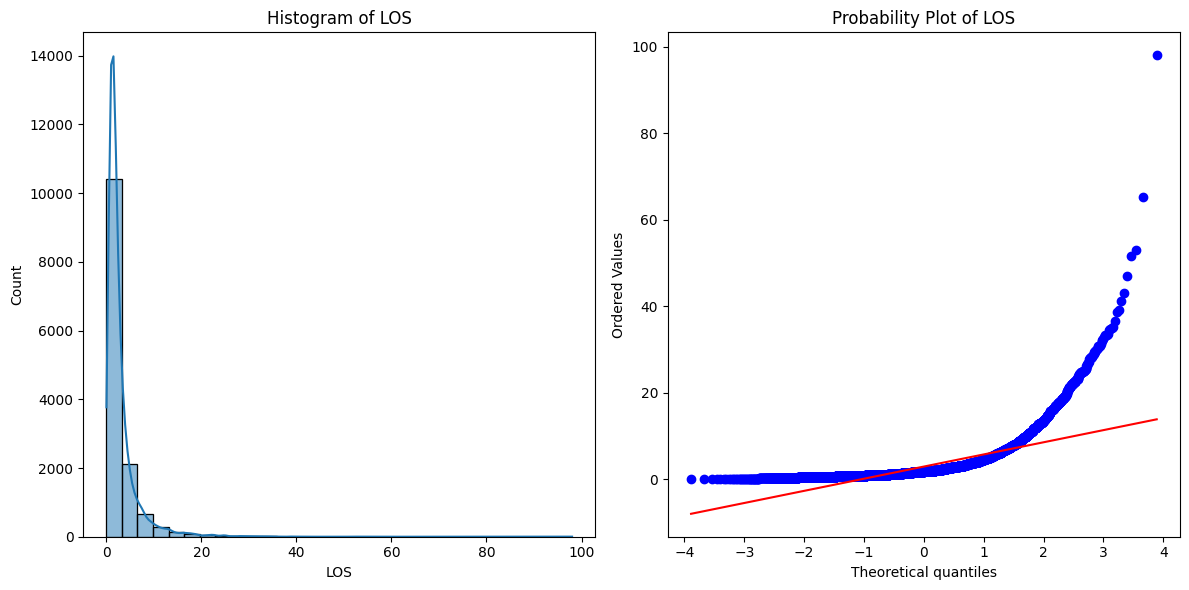

In [ ]:
from scipy.stats import probplot

plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_cardiac_ed['LOS'], bins=30, kde=True)
plt.title('Histogram of LOS')

# Probability plot
plt.subplot(1, 2, 2)
probplot(df_cardiac_ed['LOS'], plot=plt)
plt.title('Probability Plot of LOS')

plt.tight_layout()
plt.show()

In [ ]:
# make a copy of the 3 different dataset with a skew LOS column
df_cardiac_ed_skew = df_cardiac_ed.copy()
df_cardiac_ed_no_outliers_skew = df_cardiac_ed_no_outliers.copy()
df_cardiac_ed_quantile_skew = df_cardiac_ed_quantile.copy()

df_ppum_skew = df_ppum.copy()

In [ ]:
# Create 'LOS_log' column with log-transformed LOS data
df_cardiac_ed_skew['LOS_log'] = np.log1p(df_cardiac_ed_skew['LOS'])
df_cardiac_ed_no_outliers_skew['LOS_log'] = np.log1p(df_cardiac_ed_no_outliers_skew['LOS'])
df_cardiac_ed_quantile_skew['LOS_log'] = np.log1p(df_cardiac_ed_quantile_skew['LOS'])

df_ppum_skew['LOS_log'] = np.log1p(df_ppum_skew['LOS'])

In [ ]:
# Remove 'LOS' column
df_cardiac_ed_skew = df_cardiac_ed_skew.drop(['LOS'], axis=1)
df_cardiac_ed_no_outliers_skew = df_cardiac_ed_no_outliers_skew.drop(['LOS'], axis=1)
df_cardiac_ed_quantile_skew = df_cardiac_ed_quantile_skew.drop(['LOS'], axis=1)

df_ppum_skew = df_ppum_skew.drop(['LOS'], axis=1)

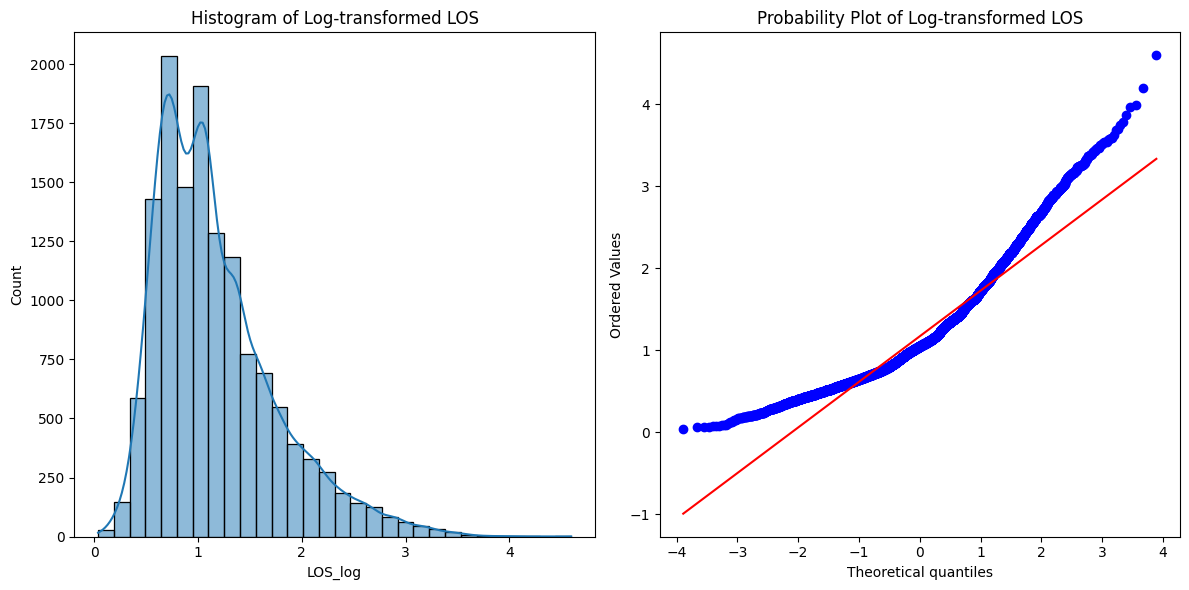

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram of log-transformed LOS
plt.subplot(1, 2, 1)
sns.histplot(df_cardiac_ed_skew['LOS_log'], bins=30, kde=True)
plt.title('Histogram of Log-transformed LOS')

# Probability plot of log-transformed LOS
plt.subplot(1, 2, 2)
probplot(df_cardiac_ed_skew['LOS_log'], plot=plt)
plt.title('Probability Plot of Log-transformed LOS')

plt.tight_layout()
plt.show()

In [ ]:
df_cardiac_ed_skew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            13801 non-null  int64  
 1   age               13801 non-null  float64
 2   diagnosis_code    13801 non-null  int64  
 3   intubated         13801 non-null  float64
 4   wbc               13801 non-null  float64
 5   respiratoryrate   13801 non-null  float64
 6   heartrate         13801 non-null  float64
 7   sodium            13801 non-null  float64
 8   meanbp            13801 non-null  float64
 9   hematocrit        13801 non-null  float64
 10  creatinine        13801 non-null  float64
 11  bun               13801 non-null  float64
 12  glucose           13801 non-null  float64
 13  thrombolytics     13801 non-null  float64
 14  metastaticcancer  13801 non-null  float64
 15  cirrhosis         13801 non-null  float64
 16  diabetes          13801 non-null  float6

## **ML Prediction** with **Normal** dataset

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, mae

def select_features(model, X_train, y_train, threshold=0.01):
    model.fit(X_train, y_train)
    feature_importance = model.feature_importances_
    selected_features = X_train.columns[feature_importance > threshold]
    return selected_features

In [ ]:
# Define features and target
X = df_cardiac_ed_skew.drop(['LOS_log'], axis=1)
y = df_cardiac_ed_skew['LOS_log']

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_ppum_scaled = scaler.transform(X_ppum)  # Scale PPUM data separately

# Initialize models
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
lgb_reg = lgb.LGBMRegressor()
svr_reg = SVR(kernel='linear')

models = [xg_reg, lgb_reg, svr_reg]
model_names = ['XGBoost', 'LightGBM', 'SVR']
results = {'Model': model_names}

for model, name in zip(models, model_names):
    # Fit model
    model.fit(X_scaled, y_train)

    # Evaluate model using cross-validation before feature selection
    scores = cross_val_score(model, X_ppum_scaled, y_ppum, scoring='neg_mean_squared_error', cv=5)
    mse_cv = -scores.mean()
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = -cross_val_score(model, X_ppum_scaled, y_ppum, scoring='neg_mean_absolute_error', cv=5).mean()
    results[name] = {'CV_MSE': mse_cv, 'CV_RMSE': rmse_cv, 'CV_MAE': mae_cv}
    print(f"{name} Model Evaluation with Cross-Validation:")
    print(f"Mean Squared Error (MSE): {mse_cv}")
    print(f"Root Mean Squared Error (RMSE): {rmse_cv}")
    print(f"Mean Absolute Error (MAE): {mae_cv}")
    print()

    # # Feature selection based on SelectFromModel with model's default importance
    # sfm = SelectFromModel(model, prefit=True)
    # X_selected = sfm.transform(X_scaled)
    # selected_features = X.columns[sfm.get_support()]

    # # Retrain the model using selected features
    # X_train_selected = X[selected_features]
    # X_ppum_selected = X_ppum[selected_features]

    # # Reshape X_train_selected
    # X_train_selected = X_train_selected.values.reshape(-1, 1)
    # # Reshape X_ppum_selected
    # X_ppum_selected = X_ppum_selected.values.reshape(-1, 1)


    # model.fit(X_train_selected, y_train)
    # mse, rmse, mae = mean_squared_error(y_ppum, model.predict(X_ppum_selected)), \
    #                  np.sqrt(mean_squared_error(y_ppum, model.predict(X_ppum_selected))), \
    #                  mean_absolute_error(y_ppum, model.predict(X_ppum_selected))
    # results[f'{name}_SFModel'] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
    # print(f"{name} Model Evaluation after SelectFromModel Feature Selection:")
    # print(f"Mean Squared Error (MSE): {mse}")
    # print(f"Root Mean Squared Error (RMSE): {rmse}")
    # print(f"Mean Absolute Error (MAE): {mae}")
    # print()

    # # Feature selection based on Recursive Feature Elimination (RFE)
    # selector = RFE(model, n_features_to_select=10, step=1)
    # selector = selector.fit(X_scaled, y_train)
    # selected_features_rfe = X.columns[selector.support_]

    # # Retrain the model using RFE selected features
    # X_train_rfe = X[selected_features_rfe]
    # X_ppum_rfe = X_ppum[selected_features_rfe]
    # model.fit(X_train_rfe, y_train)
    # mse_rfe, rmse_rfe, mae_rfe = mean_squared_error(y_ppum, model.predict(X_ppum_rfe)), \
    #                              np.sqrt(mean_squared_error(y_ppum, model.predict(X_ppum_rfe))), \
    #                              mean_absolute_error(y_ppum, model.predict(X_ppum_rfe))
    # results[f'{name}_RFE'] = {'MSE': mse_rfe, 'RMSE': rmse_rfe, 'MAE': mae_rfe}
    # print(f"{name} Model Evaluation after RFE Feature Selection:")
    # print(f"Mean Squared Error (MSE): {mse_rfe}")
    # print(f"Root Mean Squared Error (RMSE): {rmse_rfe}")
    # print(f"Mean Absolute Error (MAE): {mae_rfe}")
    # print()

XGBoost Model Evaluation with Cross-Validation:
Mean Squared Error (MSE): 0.5772972509062014
Root Mean Squared Error (RMSE): 0.7598007968580984
Mean Absolute Error (MAE): 0.5562897472012439

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 11040, number of used features: 17
[LightGBM] [Info] Start training from score 1.168650
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 1.120592
[LightGBM] [

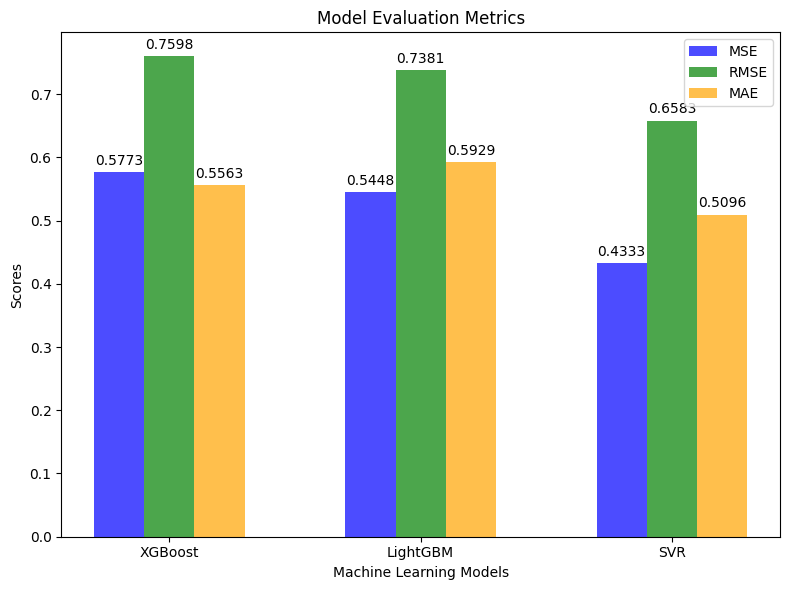

In [ ]:
# Extracting evaluation metrics from the results dictionary
model_names = results['Model']
mse_scores = [results[name]['CV_MSE'] for name in model_names]
rmse_scores = [results[name]['CV_RMSE'] for name in model_names]
mae_scores = [results[name]['CV_MAE'] for name in model_names]

# Creating grouped bar chart
bar_width = 0.2
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(8, 6))

bar1 = ax.bar(index - bar_width, mse_scores, bar_width, label='MSE', color='blue', alpha=0.7)
bar2 = ax.bar(index, rmse_scores, bar_width, label='RMSE', color='green', alpha=0.7)
bar3 = ax.bar(index + bar_width, mae_scores, bar_width, label='MAE', color='orange', alpha=0.7)

# Adding labels with metric values on each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Adding labels and adjusting layout
ax.set_xlabel('Machine Learning Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index)
ax.set_xticklabels(model_names)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

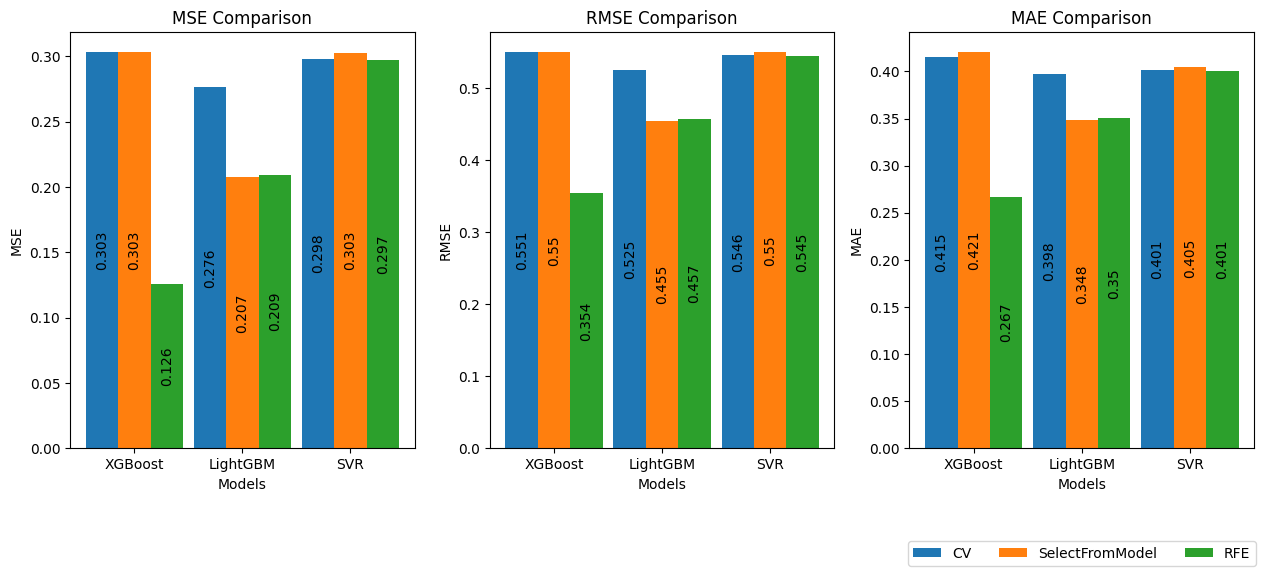

In [ ]:
# Define the list of evaluation metrics
metric_names = ['MSE', 'RMSE', 'MAE']

ind = np.arange(len(model_names))
width = 0.30

plt.figure(figsize=(13, 6))

for i, metric in enumerate(metric_names):
    plt.subplot(1, 3, i + 1)
    bars1 = plt.bar(ind, [results[model_name]['CV_' + metric] for model_name in model_names], width, label='CV')

    bars2 = plt.bar(ind + width, [results[model_name + '_SFModel'][metric] for model_name in model_names], width, label='SelectFromModel')
    bars3 = plt.bar(ind + 2 * width, [results[model_name + '_RFE'][metric] for model_name in model_names], width, label='RFE')

    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, round(yval, 3),
                     ha='center', va='center', rotation=90, color='black')

    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(ind + width, model_names)

# Create a single legend for all subplots
plt.legend(['CV', 'SelectFromModel', 'RFE'], loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel, RFE

# Define features and target
X = df_cardiac_ed_skew.drop(['LOS_log'], axis=1)
y = df_cardiac_ed_skew['LOS_log']

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize models
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
lgb_reg = lgb.LGBMRegressor()
svr_reg = SVR(kernel='linear')

# models = [xg_reg, lgb_reg, svr_reg]
# model_names = ['XGBoost', 'LightGBM', 'SVR']
# results = {'Model': model_names}

# Fit model
lgb_reg.fit(X_scaled, y)

# Evaluate model using cross-validation before feature selection
scores = cross_val_score(lgb_reg, X_scaled, y, scoring='neg_mean_squared_error', cv=5)
mse_cv = -scores.mean()
rmse_cv = np.sqrt(mse_cv)
mae_cv = -cross_val_score(lgb_reg, X_scaled, y, scoring='neg_mean_absolute_error', cv=5).mean()
# results[name] = {'CV_MSE': mse_cv, 'CV_RMSE': rmse_cv, 'CV_MAE': mae_cv}
print("LightGBM Model Evaluation with Cross-Validation:")
print(f"Mean Squared Error (MSE): {mse_cv}")
print(f"Root Mean Squared Error (RMSE): {rmse_cv}")
print(f"Mean Absolute Error (MAE): {mae_cv}")
print()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1797
[LightGBM] [Info] Number of data points in the train set: 13801, number of used features: 17
[LightGBM] [Info] Start training from score 1.170362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 11040, number of used features: 17
[LightGBM] [Info] Start training from score 1.181400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1786
[LightGBM] [Info] Number of data points in the train set: 11041, number of used features: 17
[LightGBM] [Info] Start tra

In [ ]:
# save the scaler object

# import pickle

# # save the scaler object
# with open('ml_scaler.pkl', 'wb') as file:
#   pickle.dump(scaler, file)

In [ ]:
# load the scaler object
import pickle

with open("drive/My Drive/FYP_LOS/dataset/ml_scaler.pkl", 'rb') as file:
    scaler = pickle.load(file)

In [ ]:
# Splitting the new data into features and target variable
X_new = df_ppum_skew.drop(["LOS_log"], axis=1)
y_new = df_ppum_skew["LOS_log"]

# Scaling the features data for the new data
X_new = scaler.transform(X_new)

# Make predictions using the trained DBN model
predictions = lgb_reg.predict(X_new)

# Evaluate the predictions on the new data
from sklearn.metrics import mean_squared_error

loss_new = mean_squared_error(y_new, predictions)
mae = mean_absolute_error(y_new, predictions)
rmse_new = np.sqrt(loss_new)

print("\nNew Data Test Loss:", loss_new)
print("New Data MSE:", loss_new)
print("New Data RMSE:", rmse_new)
print("New Data MAE : ", mae)


New Data Test Loss: 0.5906783314977153
New Data MSE: 0.5906783314977153
New Data RMSE: 0.7685560041387455
New Data MAE :  0.6310563222949759


## **ML Prediction** with dataset contain **no outliers**

In [ ]:
# Define features and target
X = df_cardiac_ed_no_outliers_skew.drop(['LOS_log'], axis=1)
y = df_cardiac_ed_no_outliers_skew['LOS_log']

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_ppum_scaled = scaler.transform(X_ppum)  # Scale PPUM data separately

# Initialize models
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
lgb_reg = lgb.LGBMRegressor()
svr_reg = SVR(kernel='linear')

models = [xg_reg, lgb_reg, svr_reg]
model_names = ['XGBoost', 'LightGBM', 'SVR']
results = {'Model': model_names}

for model, name in zip(models, model_names):
    # Fit model
    model.fit(X_scaled, y_train)

    # Evaluate model using cross-validation before feature selection
    scores = cross_val_score(model, X_ppum_scaled, y_ppum, scoring='neg_mean_squared_error', cv=5)
    mse_cv = -scores.mean()
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = -cross_val_score(model, X_ppum_scaled, y_ppum, scoring='neg_mean_absolute_error', cv=5).mean()
    results[name] = {'CV_MSE': mse_cv, 'CV_RMSE': rmse_cv, 'CV_MAE': mae_cv}
    print(f"{name} Model Evaluation with Cross-Validation:")
    print(f"Mean Squared Error (MSE): {mse_cv}")
    print(f"Root Mean Squared Error (RMSE): {rmse_cv}")
    print(f"Mean Absolute Error (MAE): {mae_cv}")
    print()

    # # Feature selection based on SelectFromModel with model's default importance
    # sfm = SelectFromModel(model, prefit=True)
    # X_selected = sfm.transform(X_scaled)
    # selected_features = X.columns[sfm.get_support()]

    # # Retrain the model using selected features
    # X_train_selected = X[selected_features]
    # model.fit(X_train_selected, y)
    # mse, rmse, mae = mean_squared_error(y, model.predict(X_train_selected)), \
    #                  np.sqrt(mean_squared_error(y, model.predict(X_train_selected))), \
    #                  mean_absolute_error(y, model.predict(X_train_selected))
    # results[f'{name}_SFModel'] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
    # print(f"{name} Model Evaluation after SelectFromModel Feature Selection:")
    # print(f"Mean Squared Error (MSE): {mse}")
    # print(f"Root Mean Squared Error (RMSE): {rmse}")
    # print(f"Mean Absolute Error (MAE): {mae}")
    # print()

    # # Feature selection based on Recursive Feature Elimination (RFE)
    # selector = RFE(model, n_features_to_select=10, step=1)
    # selector = selector.fit(X_scaled, y)
    # selected_features_rfe = X.columns[selector.support_]

    # # Retrain the model using RFE selected features
    # X_train_rfe = X[selected_features_rfe]
    # model.fit(X_train_rfe, y)
    # mse_rfe, rmse_rfe, mae_rfe = mean_squared_error(y, model.predict(X_train_rfe)), \
    #                              np.sqrt(mean_squared_error(y, model.predict(X_train_rfe))), \
    #                              mean_absolute_error(y, model.predict(X_train_rfe))
    # results[f'{name}_RFE'] = {'MSE': mse_rfe, 'RMSE': rmse_rfe, 'MAE': mae_rfe}
    # print(f"{name} Model Evaluation after RFE Feature Selection:")
    # print(f"Mean Squared Error (MSE): {mse_rfe}")
    # print(f"Root Mean Squared Error (RMSE): {rmse_rfe}")
    # print(f"Mean Absolute Error (MAE): {mae_rfe}")
    # print()

XGBoost Model Evaluation with Cross-Validation:
Mean Squared Error (MSE): 0.5772972509062014
Root Mean Squared Error (RMSE): 0.7598007968580984
Mean Absolute Error (MAE): 0.5562897472012439

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 2632, number of used features: 15
[LightGBM] [Info] Start training from score 0.853023
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 1.120592
[LightGBM] [W

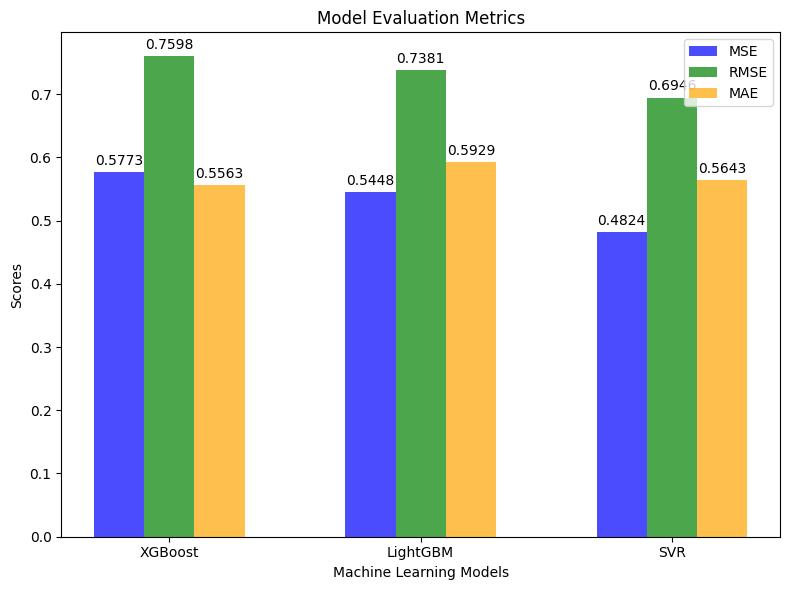

In [ ]:
# Extracting evaluation metrics from the results dictionary
model_names = results['Model']
mse_scores = [results[name]['CV_MSE'] for name in model_names]
rmse_scores = [results[name]['CV_RMSE'] for name in model_names]
mae_scores = [results[name]['CV_MAE'] for name in model_names]

# Creating grouped bar chart
bar_width = 0.2
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(8, 6))

bar1 = ax.bar(index - bar_width, mse_scores, bar_width, label='MSE', color='blue', alpha=0.7)
bar2 = ax.bar(index, rmse_scores, bar_width, label='RMSE', color='green', alpha=0.7)
bar3 = ax.bar(index + bar_width, mae_scores, bar_width, label='MAE', color='orange', alpha=0.7)

# Adding labels with metric values on each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Adding labels and adjusting layout
ax.set_xlabel('Machine Learning Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index)
ax.set_xticklabels(model_names)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

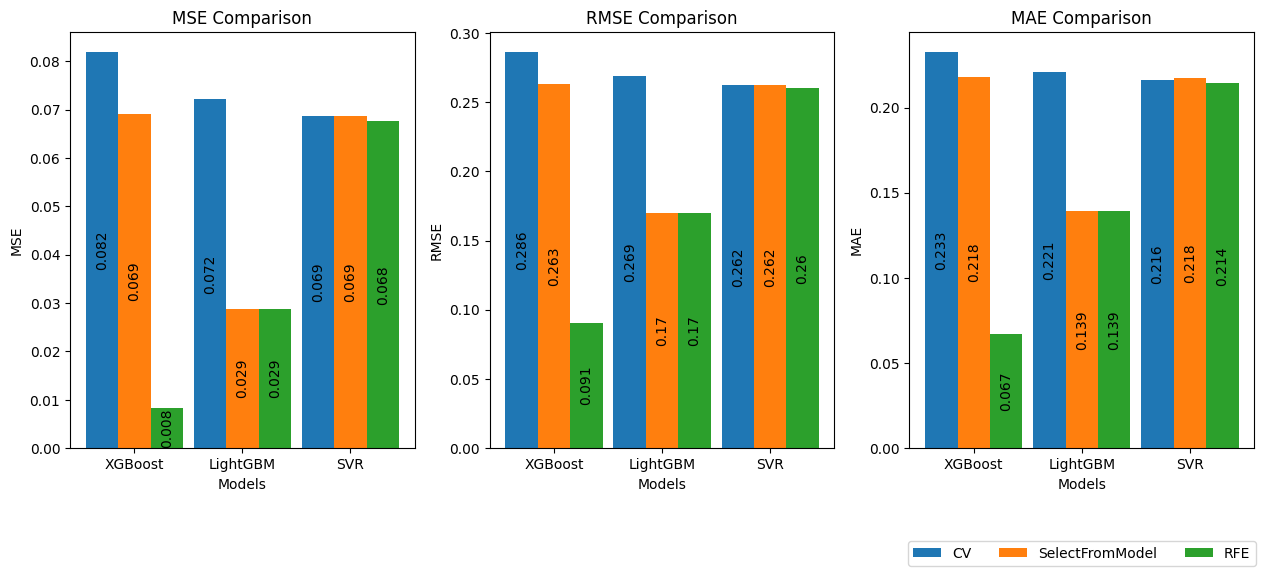

In [ ]:
# Define the list of evaluation metrics
metric_names = ['MSE', 'RMSE', 'MAE']

ind = np.arange(len(model_names))
width = 0.30

plt.figure(figsize=(13, 6))

for i, metric in enumerate(metric_names):
    plt.subplot(1, 3, i + 1)
    bars1 = plt.bar(ind, [results[model_name]['CV_' + metric] for model_name in model_names], width, label='CV')

    bars2 = plt.bar(ind + width, [results[model_name + '_SFModel'][metric] for model_name in model_names], width, label='SelectFromModel')
    bars3 = plt.bar(ind + 2 * width, [results[model_name + '_RFE'][metric] for model_name in model_names], width, label='RFE')

    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, round(yval, 3),
                     ha='center', va='center', rotation=90, color='black')

    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(ind + width, model_names)

# Create a single legend for all subplots
plt.legend(['CV', 'SelectFromModel', 'RFE'], loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.tight_layout()
plt.show()

## **ML Prediction** with Dataset using **Quantile based flooring and capping**

In [ ]:
# Define features and target
X = df_cardiac_ed_quantile_skew.drop(['LOS_log'], axis=1)
y = df_cardiac_ed_quantile_skew['LOS_log']

# PPUM (Test) Data
X_ppum = df_ppum_skew.drop(["LOS_log"], axis=1)
y_ppum = df_ppum_skew["LOS_log"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_ppum_scaled = scaler.transform(X_ppum)  # Scale PPUM data separately

# Initialize models
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
lgb_reg = lgb.LGBMRegressor()
svr_reg = SVR(kernel='linear')

models = [xg_reg, lgb_reg, svr_reg]
model_names = ['XGBoost', 'LightGBM', 'SVR']
results = {'Model': model_names}

for model, name in zip(models, model_names):
    # Fit model
    model.fit(X_scaled, y_train)

    # Evaluate model using cross-validation before feature selection
    scores = cross_val_score(model, X_ppum_scaled, y_ppum, scoring='neg_mean_squared_error', cv=5)
    mse_cv = -scores.mean()
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = -cross_val_score(model, X_ppum_scaled, y_ppum, scoring='neg_mean_absolute_error', cv=5).mean()
    results[name] = {'CV_MSE': mse_cv, 'CV_RMSE': rmse_cv, 'CV_MAE': mae_cv}
    print(f"{name} Model Evaluation with Cross-Validation:")
    print(f"Mean Squared Error (MSE): {mse_cv}")
    print(f"Root Mean Squared Error (RMSE): {rmse_cv}")
    print(f"Mean Absolute Error (MAE): {mae_cv}")
    print()

    # # Feature selection based on SelectFromModel with model's default importance
    # sfm = SelectFromModel(model, prefit=True)
    # X_selected = sfm.transform(X_scaled)
    # selected_features = X.columns[sfm.get_support()]

    # # Retrain the model using selected features
    # X_train_selected = X[selected_features]
    # model.fit(X_train_selected, y)
    # mse, rmse, mae = mean_squared_error(y, model.predict(X_train_selected)), \
    #                  np.sqrt(mean_squared_error(y, model.predict(X_train_selected))), \
    #                  mean_absolute_error(y, model.predict(X_train_selected))
    # results[f'{name}_SFModel'] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
    # print(f"{name} Model Evaluation after SelectFromModel Feature Selection:")
    # print(f"Mean Squared Error (MSE): {mse}")
    # print(f"Root Mean Squared Error (RMSE): {rmse}")
    # print(f"Mean Absolute Error (MAE): {mae}")
    # print()

    # # Feature selection based on Recursive Feature Elimination (RFE)
    # selector = RFE(model, n_features_to_select=10, step=1)
    # selector = selector.fit(X_scaled, y)
    # selected_features_rfe = X.columns[selector.support_]

    # # Retrain the model using RFE selected features
    # X_train_rfe = X[selected_features_rfe]
    # model.fit(X_train_rfe, y)
    # mse_rfe, rmse_rfe, mae_rfe = mean_squared_error(y, model.predict(X_train_rfe)), \
    #                              np.sqrt(mean_squared_error(y, model.predict(X_train_rfe))), \
    #                              mean_absolute_error(y, model.predict(X_train_rfe))
    # results[f'{name}_RFE'] = {'MSE': mse_rfe, 'RMSE': rmse_rfe, 'MAE': mae_rfe}
    # print(f"{name} Model Evaluation after RFE Feature Selection:")
    # print(f"Mean Squared Error (MSE): {mse_rfe}")
    # print(f"Root Mean Squared Error (RMSE): {rmse_rfe}")
    # print(f"Mean Absolute Error (MAE): {mae_rfe}")
    # print()

XGBoost Model Evaluation with Cross-Validation:
Mean Squared Error (MSE): 0.5772972509062014
Root Mean Squared Error (RMSE): 0.7598007968580984
Mean Absolute Error (MAE): 0.5562897472012439

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 11040, number of used features: 17
[LightGBM] [Info] Start training from score 1.122630
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 1.120592
[LightGBM] [Warning] Stopped training because there are no more leaves that 

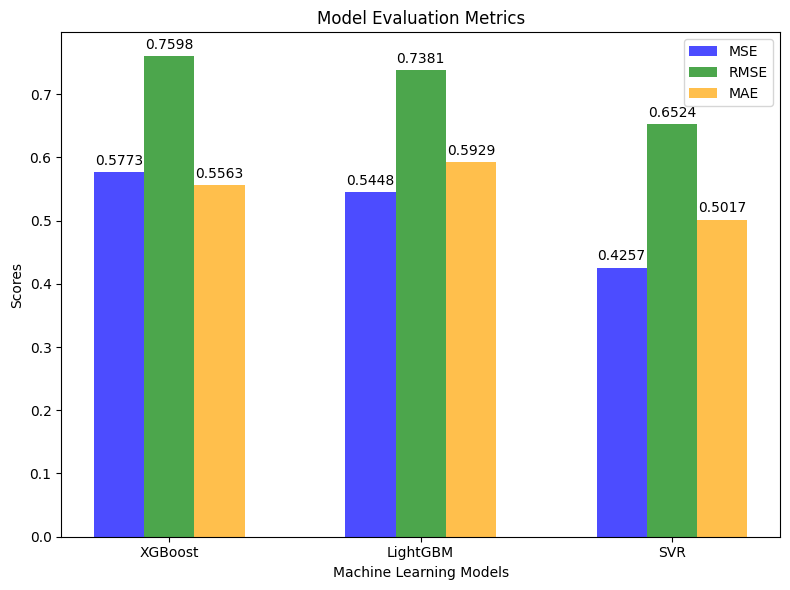

In [ ]:
# Extracting evaluation metrics from the results dictionary
model_names = results['Model']
mse_scores = [results[name]['CV_MSE'] for name in model_names]
rmse_scores = [results[name]['CV_RMSE'] for name in model_names]
mae_scores = [results[name]['CV_MAE'] for name in model_names]

# Creating grouped bar chart
bar_width = 0.2
index = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(8, 6))

bar1 = ax.bar(index - bar_width, mse_scores, bar_width, label='MSE', color='blue', alpha=0.7)
bar2 = ax.bar(index, rmse_scores, bar_width, label='RMSE', color='green', alpha=0.7)
bar3 = ax.bar(index + bar_width, mae_scores, bar_width, label='MAE', color='orange', alpha=0.7)

# Adding labels with metric values on each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Adding labels and adjusting layout
ax.set_xlabel('Machine Learning Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index)
ax.set_xticklabels(model_names)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

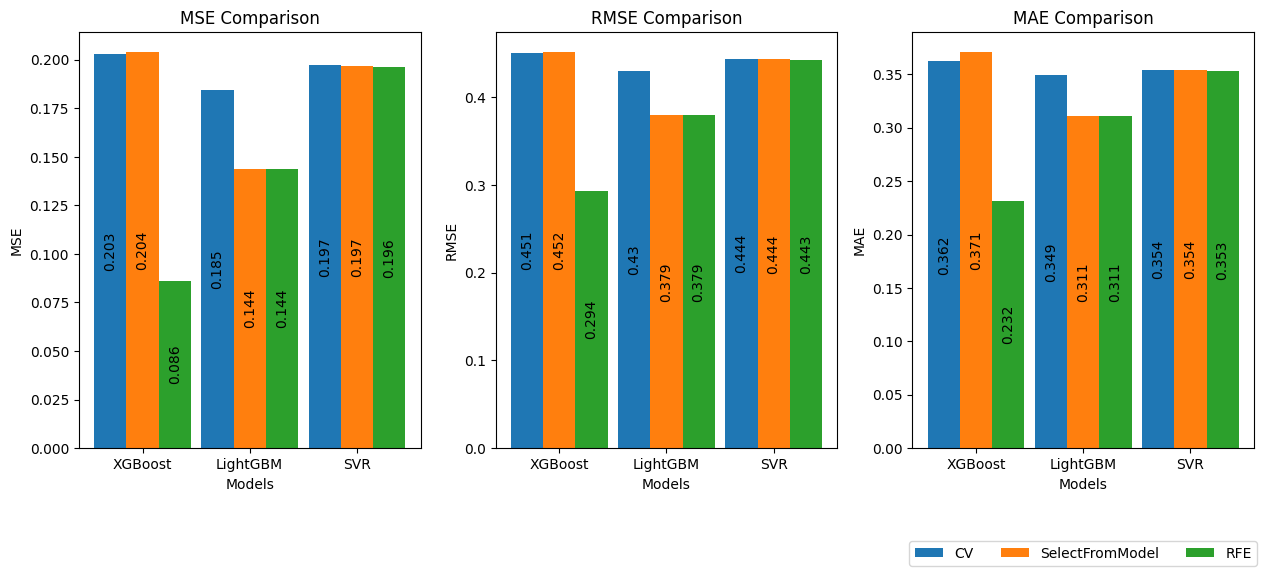

In [ ]:
# Define the list of evaluation metrics
metric_names = ['MSE', 'RMSE', 'MAE']

ind = np.arange(len(model_names))
width = 0.30

plt.figure(figsize=(13, 6))

for i, metric in enumerate(metric_names):
    plt.subplot(1, 3, i + 1)
    bars1 = plt.bar(ind, [results[model_name]['CV_' + metric] for model_name in model_names], width, label='CV')

    bars2 = plt.bar(ind + width, [results[model_name + '_SFModel'][metric] for model_name in model_names], width, label='SelectFromModel')
    bars3 = plt.bar(ind + 2 * width, [results[model_name + '_RFE'][metric] for model_name in model_names], width, label='RFE')

    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, round(yval, 3),
                     ha='center', va='center', rotation=90, color='black')

    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(ind + width, model_names)

# Create a single legend for all subplots
plt.legend(['CV', 'SelectFromModel', 'RFE'], loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel, RFE

# Define features and target
X = df_cardiac_ed_quantile_skew.drop(['LOS_log'], axis=1)
y = df_cardiac_ed_quantile_skew['LOS_log']

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize models
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
lgb_reg = lgb.LGBMRegressor()
svr_reg = SVR(kernel='linear')

# models = [xg_reg, lgb_reg, svr_reg]
# model_names = ['XGBoost', 'LightGBM', 'SVR']
# results = {'Model': model_names}

# Fit model
lgb_reg.fit(X_scaled, y)

# Evaluate model using cross-validation before feature selection
scores = cross_val_score(lgb_reg, X_scaled, y, scoring='neg_mean_squared_error', cv=5)
mse_cv = -scores.mean()
rmse_cv = np.sqrt(mse_cv)
mae_cv = -cross_val_score(lgb_reg, X_scaled, y, scoring='neg_mean_absolute_error', cv=5).mean()
# results[name] = {'CV_MSE': mse_cv, 'CV_RMSE': rmse_cv, 'CV_MAE': mae_cv}
print("LightGBM Model Evaluation with Cross-Validation:")
print(f"Mean Squared Error (MSE): {mse_cv}")
print(f"Root Mean Squared Error (RMSE): {rmse_cv}")
print(f"Mean Absolute Error (MAE): {mae_cv}")
print()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 13801, number of used features: 17
[LightGBM] [Info] Start training from score 1.124254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 11040, number of used features: 17
[LightGBM] [Info] Start training from score 1.132937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 11041, number of used features: 17
[LightGBM] [Info] Start tra

In [ ]:
# load the scaler object
import pickle

with open("drive/My Drive/FYP_LOS/dataset/ml_scaler.pkl", 'rb') as file:
    scaler = pickle.load(file)

In [ ]:
# Splitting the new data into features and target variable
X_new = df_ppum_skew.drop(["LOS_log"], axis=1)
y_new = df_ppum_skew["LOS_log"]

# Scaling the features data for the new data
X_new = scaler.transform(X_new)

# Make predictions using the trained DBN model
predictions = lgb_reg.predict(X_new)

# Evaluate the predictions on the new data
loss_new = mean_squared_error(y_new, predictions)
mae = mean_absolute_error(y_new, predictions)
rmse_new = np.sqrt(loss_new)

print("\nNew Data Test Loss:", loss_new)
print("New Data MSE:", loss_new)
print("New Data RMSE:", rmse_new)
print("New Data MAE:", mae)


New Data Test Loss: 0.5020236171561279
New Data MSE: 0.5020236171561279
New Data RMSE: 0.7085362497121286
New Data MAE: 0.5893257717221931


In [ ]:
import pandas as pd

# Create a dictionary with the given data
data = {
    'Dataset': ['normal dataset', 'no outliers', 'Quantile'],
    'Model': ['LightGBM', 'SVR', 'LightGBM'],
    'MSE': [0.5020236171561279, 0.5195799639873472, 0.5020236171561279],
    'RMSE': [0.7085362497121286, 0.7208189536820929, 0.7085362497121286],
    'MAE': [0.5893257717221931, 0.583612931444361, 0.5893257717221931]
}

# Create a dataframe from the dictionary
df = pd.DataFrame(data)

# Round the values to 3 decimal points
df = df.round(3)

# Display the dataframe
df

,Dataset,Model,MSE,RMSE,MAE
0,normal dataset,LightGBM,0.502,0.709,0.589
1,no outliers,SVR,0.520,0.721,0.584
2,Quantile,LightGBM,0.502,0.709,0.589
